学习算法公平性。

In [ ]:
library(mlr3fairness)
library(mlr3verse)
tsk_adult_train <- tsk("adult_train")
tsk_adult_train

# <TaskClassif:adult_train> (30718 x 13)
# * Target: target
# * Properties: twoclass
# * Features (12):
#   - fct (7): education, marital_status, occupation, race, relationship,
#     sex, workclass
#   - int (5): age, capital_gain, capital_loss, education_num,
#     hours_per_week
# * Protected attribute: sex

Loading required package: mlr3



<TaskClassif:adult_train> (30718 x 13)
* Target: target
* Properties: twoclass
* Features (12):
  - fct (7): education, marital_status, occupation, race, relationship,
    sex, workclass
  - int (5): age, capital_gain, capital_loss, education_num,
    hours_per_week
* Protected attribute: sex

# 偏见与公平性

In [ ]:
sex_salary <- table(tsk_adult_train$data(cols = c("sex", "target")))
round(proportions(sex_salary), 2)

# target
# sex      <=50K >50K
#   Female  0.29 0.04
#   Male    0.46 0.21

        target
sex      <=50K >50K
  Female  0.29 0.04
  Male    0.46 0.21

In [ ]:
chisq.test(sex_salary)

# Pearson's Chi-squared test with Yates' continuity correction

# data:  sex_salary
# X-squared = 1440.4, df = 1, p-value < 2.2e-16


	Pearson's Chi-squared test with Yates' continuity correction

data:  sex_salary
X-squared = 1440.4, df = 1, p-value < 2.2e-16


In [6]:
tsk_adult_train$set_col_roles("sex", add_to = "pta")

In [ ]:
fair_tpr <- msr("fairness", base_measure = msr("classif.tpr"), range = c(0, 1))
fair_tpr

# <MeasureFairness:fairness.tpr>
# * Packages: mlr3, mlr3fairness
# * Range: [0, 1]
# * Minimize: TRUE
# * Average: macro
# * Parameters: list()
# * Properties: requires_task
# * Predict type: response

<MeasureFairness:fairness.tpr>
* Packages: mlr3, mlr3fairness
* Range: [0, 1]
* Minimize: TRUE
* Average: macro
* Parameters: list()
* Properties: requires_task
* Predict type: response

# 模型偏见审计

In [ ]:
tsk_adult_test <- tsk("adult_test")
lrn_rpart <- lrn("classif.rpart", predict_type = "prob")
prediction <- lrn_rpart$train(tsk_adult_train)$predict(tsk_adult_test)
prediction$score(fair_tpr, tsk_adult_test)

# fairness.tpr 
#   0.06034495

fairness.tpr 
  0.06034495

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


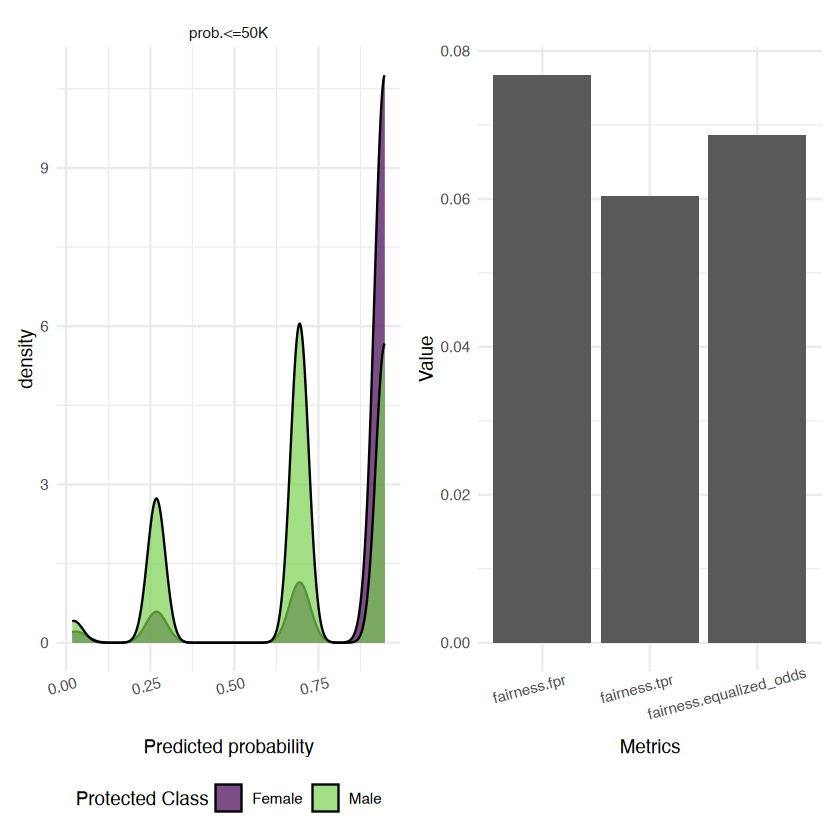

In [ ]:
library(patchwork)
library(ggplot2)

p1 <- fairness_prediction_density(prediction, task = tsk_adult_test)
p2 <- compare_metrics(prediction,
  msrs(c("fairness.fpr", "fairness.tpr", "fairness.eod")),
  task = tsk_adult_test
)

(p1 + p2) *
  theme_minimal() *
  scale_fill_viridis_d(end = 0.8, alpha = 0.8) *
  theme(
    axis.text.x = element_text(angle = 15, hjust = .7),
    legend.position = "bottom"
  )

# 公平机器学习

In [ ]:
# load learners
lrn_rpart <- lrn("classif.rpart", predict_type = "prob")
lrn_rpart$id <- "rpart"

l1 <- as_learner(po("reweighing_wts") %>>% lrn("classif.rpart"))
l1$id <- "reweight"

l2 <- as_learner(po("learner_cv", lrn("classif.rpart")) %>>% po("EOd"))
l2$id <- "EOd"

# preprocess by collapsing factors
l3 <- as_learner(po("collapsefactors") %>>% lrn("classif.fairzlrm"))
l3$id <- "fairzlrm"

# load task and subset by rows and columns
task <- tsk("adult_train")
task$set_col_roles("sex", "pta")$
  filter(sample(task$nrow, 500))$
  select(setdiff(task$feature_names, "education_num"))

# run experiment
lrns <- list(lrn_rpart, l1, l2, l3)
bmr <- benchmark(benchmark_grid(task, lrns, rsmp("cv", folds = 5)))
meas <- msrs(c("classif.acc", "fairness.eod"))
bmr$aggregate(meas)[, .(learner_id, classif.acc, fairness.equalized_odds)]

# learner_id classif.acc fairness.equalized_odds
# 1 rpart      0.788       0.2758117              
# 2 reweight   0.786       0.2256930              
# 3 EOd        0.780       0.2352123              
# 4 fairzlrm   0.794       0.2416989

INFO  [14:05:14.241] [mlr3] Running benchmark with 20 resampling iterations
INFO  [14:05:14.256] [mlr3] Applying learner 'rpart' on task 'adult_train' (iter 1/5)
INFO  [14:05:14.391] [mlr3] Applying learner 'rpart' on task 'adult_train' (iter 2/5)
INFO  [14:05:14.430] [mlr3] Applying learner 'rpart' on task 'adult_train' (iter 3/5)
INFO  [14:05:14.447] [mlr3] Applying learner 'rpart' on task 'adult_train' (iter 4/5)
INFO  [14:05:14.459] [mlr3] Applying learner 'rpart' on task 'adult_train' (iter 5/5)
INFO  [14:05:14.472] [mlr3] Applying learner 'reweight' on task 'adult_train' (iter 1/5)
INFO  [14:05:14.521] [mlr3] Applying learner 'reweight' on task 'adult_train' (iter 2/5)
INFO  [14:05:14.571] [mlr3] Applying learner 'reweight' on task 'adult_train' (iter 3/5)
INFO  [14:05:14.630] [mlr3] Applying learner 'reweight' on task 'adult_train' (iter 4/5)
INFO  [14:05:14.671] [mlr3] Applying learner 'reweight' on task 'adult_train' (iter 5/5)
INFO  [14:05:14.715] [mlr3] Applying learner 'EOd

learner_id,classif.acc,fairness.equalized_odds
<chr>,<dbl>,<dbl>
rpart,0.788,0.2758117
reweight,0.786,0.2256930
EOd,0.780,0.2352123
fairzlrm,0.794,0.2416989


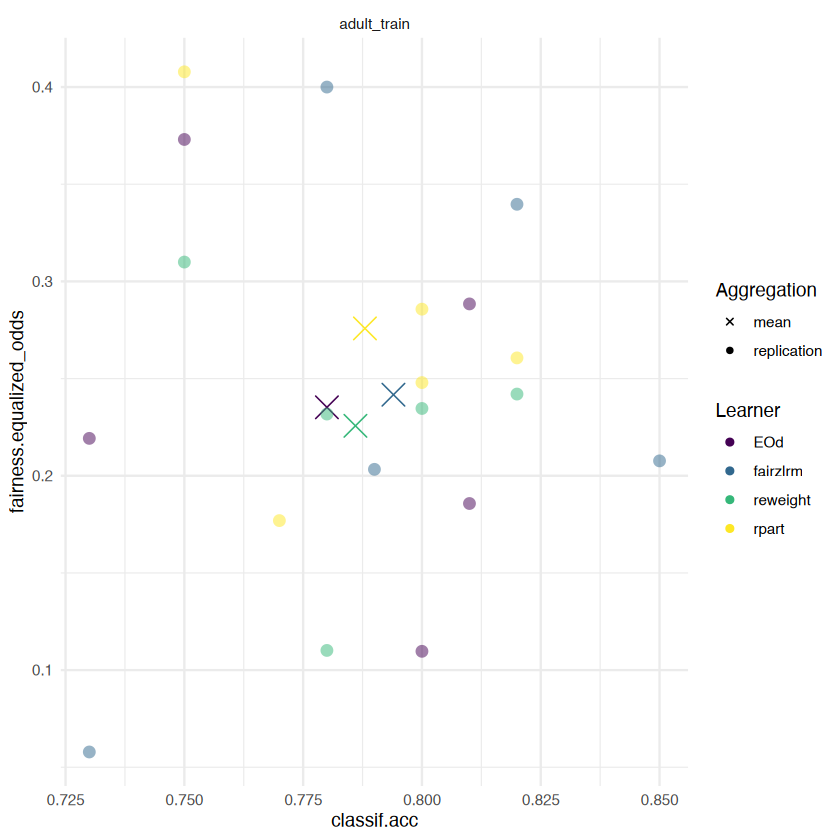

In [16]:
fairness_accuracy_tradeoff(
  bmr,
  fairness_measure = msr("fairness.eod"),
  accuracy_measure = msr("classif.ce")
) +
  ggplot2::scale_color_viridis_d("Learner") +
  ggplot2::theme_minimal()